This notebook continues on from '2-mush-obs-images.ipynb' where I downloaded images into classes. This notebook will begin training and testing classification models on the image data. 

## Setting Up the Workspace

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#!pip install fastai --upgrade -q

In [2]:
from fastai.vision.all import * # for ease of use
from fastai.data.all import *
from fastai.metrics import error_rate
import os, math, numpy, pandas as pd

In [3]:
# For mounting google drive

#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#datapath = Path('/content/drive/MyDrive/Colab Notebooks/mushroom-proj/data')
datapath = Path.cwd() / 'data'
datapath

Path('/notebooks/storage/mushroom_obs/data')

In [5]:
mushroom_images = Path(datapath/'mushroom-images')

### Experimental Setup

Before training a species classifier, I want to remove images uploaded that are not of mushrooms. The database contains images of spores, or sometimes people holding mushrooms where the mushroom is not very visible, so first I want to build a binary 'mushroom-or-not classifier'. I'll take 3 images from every class to make a 'mushroom' class, and then manually scan through and collect a few tens of images of spores, or people holding mushrooms to create a 'not mushroom' class. 

In [52]:
classes = [f for f in mushroom_images.iterdir() if f.is_dir()]

In [53]:
len(classes)

992

In [12]:
#mushrooms = Path(datapath/'mushrooms')
#mushrooms.mkdir()

In [13]:
#im_nums = list(range(len(classes)*3))

In [20]:
#im_num=0
#for i, c in enumerate(classes):
#    paths = list(c.rglob('*.jpg'))[:3]
#    for p in paths:
#        name = str(im_nums[im_num]) + '.jpg'
#        out_file = Path(mushrooms/name)
#        im_num+=1
#        shutil.copy(p, out_file)

I've created a mushrooms folder and a 'not mushrooms' folder to build a mushroom or not classifier. I will train the classifier and then make predictions on every image I have gathered to remove 'junk' images. 

In [7]:
mushroom_or_not = Path(datapath/'mushroom_or_not')

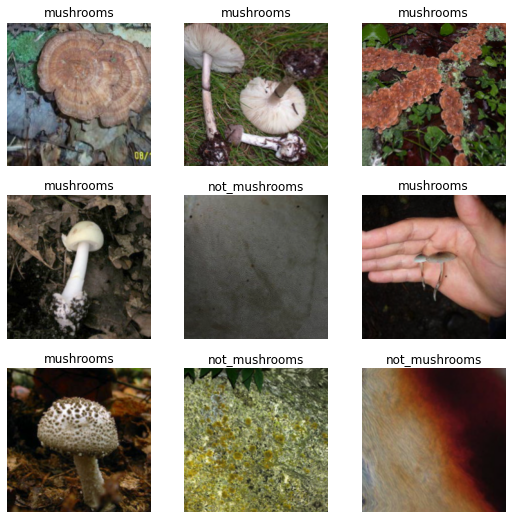

In [8]:
# Loading the two classes: mushrooms and not_mushrooms into the fastai module
mushroom_db = DataBlock(blocks = (ImageBlock, CategoryBlock), # inputs are images, outputs are categoriesb
                   get_items = get_image_files,   # get images from folder names
                   get_y = parent_label,          # get labels by processing filename
                   splitter = RandomSplitter(valid_pct=0.2, seed=0),
                   item_tfms = Resize(224),       # resize all images to 224 x 224
                   batch_tfms = aug_transforms()) # augment images to improve generalisation
mushroom_dl = mushroom_db.dataloaders(mushroom_or_not)
mushroom_dl.show_batch(max_n=9)

In [24]:
learn = cnn_learner(mushroom_dl, resnet34, metrics=error_rate)

In [25]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.903561,0.449491,0.152733,00:10
1,0.572359,0.282627,0.102894,00:10
2,0.381879,0.281153,0.069132,00:10
3,0.280210,0.260902,0.075563,00:10


In [26]:
learn.unfreeze()

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=9.999999747378752e-06)

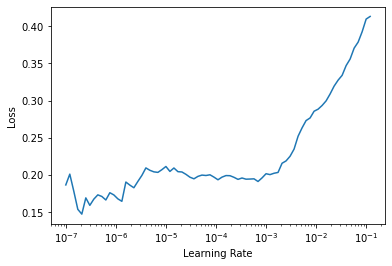

In [27]:
learn.lr_find()

In [28]:
learn.fit_one_cycle(6, lr_max=slice(1e-5, 5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.181516,0.246858,0.080386,00:13
1,0.179475,0.262846,0.078778,00:13
2,0.143233,0.251243,0.073955,00:13
3,0.112241,0.270038,0.069132,00:13
4,0.093037,0.272993,0.070740,00:13
5,0.074118,0.254860,0.069132,00:13


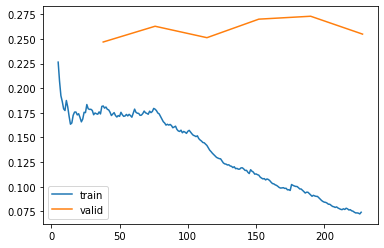

In [29]:
learn.recorder.plot_loss()

So now we have a 'mushroom or not' classifier we can use it to check for junk images in the mushroom observer dataset. 

In [30]:
# Saving the model incase we want to come back to this state
#learn.save('mushroom_or_not')

Path('models/mushroom_or_not.pth')

In [32]:
# exporting the model for use with inference
#learn.export('models/mushroom_or_not_EXPORT.pkl')

In [6]:
bad_mushroom_images = datapath / Path('bad_mushroom_images')
bad_mushroom_images.mkdir(exist_ok=True)

In [48]:
from shutil import copy

In [51]:
#from shutil import rmtree
#rmtree(bad_mushroom_images)

In [53]:
# First i'm going to delete any images that can't be opened 
deleted = []
del_count = 0
for im in mushroom_images.rglob("*.jpg"):
    try:
        load_image(im)
    except:
        im.unlink()
        deleted.append(im)
        del_count += 1

In [ ]:
# copy all images predicted as 'not mushrooms' to a new folder
bad_images = []

for i, im in enumerate(mushroom_images.rglob("*.jpg")):
    cat, tensor, probs = learn.predict(im);
    if cat == 'not_mushrooms':
        species = im.parent.stem
        fnum = im.stem
        dest_folder = bad_mushroom_images / Path(species) 
        dest_folder.mkdir(exist_ok=True)
        dest = dest_folder / Path(str(fnum) + '.jpg')
        copy(im, dest) 
        bad_images.append(im)

In [7]:
bad_images = []
for im in bad_mushroom_images.rglob('*.jpg'):
    species = im.parent.stem
    fnum = im.stem
    dest = mushroom_images / Path(species) / Path(str(fnum)+'jpg') 
    bad_images.append(dest)
    

In [8]:
len(bad_images)

19208

In [9]:
bad_images[:20]

[Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Scutiger-pes-caprae/00000055jpg'),
 Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Scutiger-pes-caprae/00000002jpg'),
 Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Scutiger-pes-caprae/00000050jpg'),
 Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Scutiger-pes-caprae/00000045jpg'),
 Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Scutiger-pes-caprae/00000056jpg'),
 Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Cortinarius-glutinosoarmillatus/00000091jpg'),
 Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Cortinarius-glutinosoarmillatus/00000108jpg'),
 Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Cortinarius-glutinosoarmillatus/00000006jpg'),
 Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Cortinarius-glutinosoarmillatus/00000011jpg'),
 Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Cortinarius-glutinosoarmillatus/00000

In [11]:
import csv
def paths_to_csv(path_list):
    path_list = [str(p) for p in path_list]    
    with open(datapath / Path('bad_images.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(path_list)
paths_to_csv(bad_images)  

Now we have the images which are not of mushrooms in a separate folder, we can delete them from the mushroom images folder. 

In [12]:
for im in bad_images:
    im.unlink

We should check that there are no species left that have only a handful of images, if there are, we should copy these over to the bad images folder too. 

In [40]:
species = [f for f in mushroom_images.iterdir() if f.is_dir()]
low_species = []
for s in species:
    files = [f for f in s.rglob("*.jpg")]
    num_files = len(files)
    if num_files <= 30:
        low_species.append(s)

In [41]:
len(low_species)

7

In [42]:
low_species

[Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Lactarius-glaucescens'),
 Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Suillus-ponderosus'),
 Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Russula-olivacea'),
 Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Helvella-leucomelaena'),
 Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Micromphale-sequoiae'),
 Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Russula-virescens'),
 Path('/notebooks/storage/mushroom_obs/data/mushroom-images/Russula-amoenolens')]

In [44]:
from shutil import copy
for l in low_species:
    for im in l.rglob("*.jpg"):
        species = im.parent.stem
        fnum = im.stem
        dest_folder = bad_mushroom_images / Path(species) 
        dest_folder.mkdir(exist_ok=True)
        dest = dest_folder / Path(str(fnum) + '.jpg')
        copy(im, dest)
        im.unlink()

In [51]:
for l in low_species:
    for f in l.glob("*"):
        f.unlink()
    l.rmdir()

Now we have 992 classes of clean images and we can start training models to predict a mushroom species from its image.

### Models to Predict a Mushroom Species from its Image

I'll use a 80:10:10 split for training, validation, and test sets. We will set aside the test data manually, and use the FastAI Datablock API for training and validation splits. 

In [54]:
# Get a random 10pct of filenames as the test set
fnames = get_image_files(mushroom_images)
random.seed(0)
test_fnames = random.sample(fnames, round(0.1*len(fnames)))

In [55]:
# create a test directory in the datapath
test_data = Path(datapath/'test_data')
test_data.mkdir(exist_ok=True)

In [56]:
# Once files are moved, this cell will produce an error!
target = test_data
# move all test images to the test_data directory, keeping their folder labels
for f in test_fnames:
    new_name = Path(f.parent.stem) / Path(f.stem)
    new_dir = test_data / Path(f.parent.stem)
    new_dir.mkdir(exist_ok=True)
    f.rename(target.joinpath(new_name))

Now we have a seperate test set containing a random 10% subset of all images. The test set is labelled so that we can check our accurate the predictions are. The test set will now not be used until all candidate models are trained on the validation set. Predictions will then be made once only on the test set for each candidate model. 

In [6]:
# get further 11.1 % of training set as 10 % test set
valid_pct = 0.1111 # percentage to take from training to make overall test set 10%

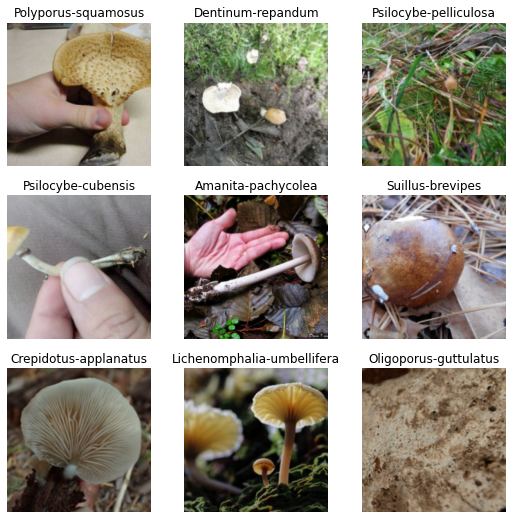

In [7]:
# function to process filenames (Path objects) into class labels

mushroom_db = DataBlock(blocks = (ImageBlock, CategoryBlock), # inputs are images, outputs are categories
                   get_items = get_image_files,   # get images from folder names
                   get_y = parent_label,          # get labels by processing filename
                   splitter = RandomSplitter(valid_pct=valid_pct, seed=0),
                   item_tfms = Resize(224),       # resize all images to 224 x 224
                   batch_tfms = aug_transforms()) # augment images to improve generalisation
mushroom_dl = mushroom_db.dataloaders(mushroom_images)
mushroom_dl.show_batch(max_n=9)


## Training Models

Now that we have our data split correctly into training, validation, and test sets, we can begin training and evaluating models. 

In [8]:
learn = cnn_learner(mushroom_dl, resnet34, metrics=accuracy)

In [9]:
learn.fine_tune(14, freeze_epochs=6, cbs=SaveModelCallback(monitor='valid_loss', fname='species-resnet34'))

epoch,train_loss,valid_loss,accuracy,time
0,5.888876,4.984786,0.148931,11:24
1,4.410781,3.762519,0.266958,10:33
2,3.904086,3.298206,0.321331,11:08
3,3.780636,3.140230,0.345287,11:37
4,3.661739,3.032792,0.365695,10:22
5,3.519074,2.900455,0.385957,10:21


Better model found at epoch 0 with valid_loss value: 4.984785556793213.
Better model found at epoch 1 with valid_loss value: 3.762519359588623.
Better model found at epoch 2 with valid_loss value: 3.298205614089966.
Better model found at epoch 3 with valid_loss value: 3.140230417251587.
Better model found at epoch 4 with valid_loss value: 3.03279185295105.
Better model found at epoch 5 with valid_loss value: 2.9004547595977783.


/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,accuracy,time
0,2.900420,2.466579,0.456948,14:23
1,2.705581,2.312022,0.480224,13:28
2,2.701507,2.247478,0.491837,13:24
3,2.558079,2.216379,0.491788,14:12
4,2.402130,2.076406,0.521380,14:51
5,2.263506,2.006247,0.536249,14:47
6,2.000585,1.878606,0.566278,13:22
7,1.872207,1.777968,0.588970,13:35
8,1.691942,1.703765,0.603839,13:50
9,1.508541,1.632716,0.617444,14:17


Better model found at epoch 0 with valid_loss value: 2.466578960418701.
Better model found at epoch 1 with valid_loss value: 2.3120219707489014.
Better model found at epoch 2 with valid_loss value: 2.247478485107422.
Better model found at epoch 3 with valid_loss value: 2.216379165649414.
Better model found at epoch 4 with valid_loss value: 2.0764057636260986.
Better model found at epoch 5 with valid_loss value: 2.0062472820281982.
Better model found at epoch 6 with valid_loss value: 1.878605842590332.
Better model found at epoch 7 with valid_loss value: 1.777968168258667.
Better model found at epoch 8 with valid_loss value: 1.7037650346755981.
Better model found at epoch 9 with valid_loss value: 1.6327157020568848.
Better model found at epoch 10 with valid_loss value: 1.583884596824646.
Better model found at epoch 11 with valid_loss value: 1.555090069770813.
Better model found at epoch 12 with valid_loss value: 1.5396690368652344.
Better model found at epoch 13 with valid_loss value: 1

In [9]:
learn.load('species-resnet34')

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [10]:
learn.export('models/species-resnet34_EXPORT.pkl')

So we have a model that is 62 % accurate on the validation set using vanilla resnet34, pre-trained on imagenet and transfer learned to the mushroom database. The next model to try is resnet50 with some adjustments made in the 'bag of tricks paper'. 